In [15]:
import pandas as pd

# Load dataset
data_path = '../../data/processed/Retail_Sales_Data_with_Products.csv'
df = pd.read_csv(data_path)

# Filter data for Retailer1 only (if required)
df_retailer1 = df[df['retailer'] == 'retail1'].copy()
print("Initial Data Sample:")
print(df_retailer1.head())
print("\nData Types:")
print(df_retailer1.dtypes)


Initial Data Sample:
  retailer  store_id  week                   product  \
0  retail1         1     1       MintyFresh Mint 18g   
1  retail1         1     1    ChocoDelight Dark 200g   
2  retail1         1     1   ChocoDelight White 350g   
3  retail1         1     1  NuttyCream Hazelnuts 80g   
4  retail1         1     1        DarkDream Dark 60g   

                                         description  regular_price  \
0                    MintyFresh refresh mint 18grams      10.308645   
1                           200g ChocoDelight smooth       7.947956   
2                        350g ChocoDelight delicious      13.439368   
3                delightful Hazelnuts 80g NuttyCream       5.112777   
4  A decadent DarkDream dark chocolate ice cream ...      14.085425   

   competition_1_regular_price  competition_2_regular_price  \
0                    10.624815                    10.013451   
1                     7.748726                     7.589198   
2                    13.75

In [16]:
# Drop unnecessary columns
df_retailer1 = df_retailer1.drop(columns=['retailer', 'product', 'description'])

# One-hot encode 'brand' if it exists as a categorical feature
if 'brand' in df_retailer1.columns:
    df_retailer1 = pd.get_dummies(df_retailer1, columns=['brand'], drop_first=True)


In [17]:
# Remove 'g' suffix and convert to float, setting missing or non-numeric weights to 0
df_retailer1['weight'] = df_retailer1['weight'].replace('g', '', regex=True)
df_retailer1['weight'] = pd.to_numeric(df_retailer1['weight'], errors='coerce').fillna(0)

# Verify the conversion
print("Weight Column After Conversion:")
print(df_retailer1['weight'].head())


Weight Column After Conversion:
0      0.0
1    200.0
2    350.0
3     80.0
4      0.0
Name: weight, dtype: float64


In [18]:
# Fill NaN promo prices with 0 (assuming missing values mean no promotion)
promo_columns = [col for col in df_retailer1.columns if 'promo_price' in col]
df_retailer1[promo_columns] = df_retailer1[promo_columns].fillna(0)

# Fill remaining missing values in numeric columns with the mean or median
df_retailer1 = df_retailer1.fillna(df_retailer1.mean())

# Verify that there are no remaining missing values
print("Missing Values After Filling:")
print(df_retailer1.isnull().sum())


Missing Values After Filling:
store_id                        0
week                            0
regular_price                   0
competition_1_regular_price     0
competition_2_regular_price     0
competition_3_regular_price     0
competition_4_regular_price     0
competition_5_regular_price     0
competition_6_regular_price     0
competition_7_regular_price     0
competition_8_regular_price     0
competition_9_regular_price     0
competition_10_regular_price    0
promo_price                     0
competition_1_promo_price       0
competition_2_promo_price       0
competition_3_promo_price       0
competition_4_promo_price       0
competition_5_promo_price       0
competition_6_promo_price       0
competition_7_promo_price       0
competition_8_promo_price       0
competition_9_promo_price       0
competition_10_promo_price      0
value                           0
volume                          0
quantity                        0
weight                          0
brand_DarkDream   

In [19]:
import numpy as np

# Calculate average competition price
comp_price_cols = [col for col in df_retailer1.columns if 'competition_' in col and 'regular_price' in col]
df_retailer1['avg_competition_price'] = df_retailer1[comp_price_cols].mean(axis=1)
df_retailer1['price_difference'] = df_retailer1['regular_price'] - df_retailer1['avg_competition_price']

# Add seasonality indicators based on 'week'
df_retailer1['sin_week'] = np.sin(2 * np.pi * df_retailer1['week'] / max(df_retailer1['week']))
df_retailer1['cos_week'] = np.cos(2 * np.pi * df_retailer1['week'] / max(df_retailer1['week']))

# Interaction term between price difference and promo price
df_retailer1['price_promo_interaction'] = df_retailer1['price_difference'] * df_retailer1['promo_price']


In [20]:
# Verify data types
print("Data Types After Processing:")
print(df_retailer1.dtypes)

# Display the cleaned data sample
print("\nCleaned Data Sample:")
print(df_retailer1.head())


Data Types After Processing:
store_id                          int64
week                              int64
regular_price                   float64
competition_1_regular_price     float64
competition_2_regular_price     float64
competition_3_regular_price     float64
competition_4_regular_price     float64
competition_5_regular_price     float64
competition_6_regular_price     float64
competition_7_regular_price     float64
competition_8_regular_price     float64
competition_9_regular_price     float64
competition_10_regular_price    float64
promo_price                     float64
competition_1_promo_price       float64
competition_2_promo_price       float64
competition_3_promo_price       float64
competition_4_promo_price       float64
competition_5_promo_price       float64
competition_6_promo_price       float64
competition_7_promo_price       float64
competition_8_promo_price       float64
competition_9_promo_price       float64
competition_10_promo_price      float64
value      

In [21]:
# Define features (X) and target (y)
X = df_retailer1.drop(columns=['quantity'])
y = df_retailer1['quantity']

# Verify the shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (5200, 35)
Shape of y: (5200,)


In [22]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)


Training set size: (4160, 35)
Testing set size: (1040, 35)


In [23]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)

# Train the model
gbr.fit(X_train, y_train)

# Predict on the test set
y_pred = gbr.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Gradient Boosting Model - Mean Squared Error (MSE): {mse}")
print(f"Gradient Boosting Model - Mean Absolute Error (MAE): {mae}")
print(f"Gradient Boosting Model - R-squared (R²): {r2}")


Gradient Boosting Model - Mean Squared Error (MSE): 8.476403959731096
Gradient Boosting Model - Mean Absolute Error (MAE): 2.5346066258283
Gradient Boosting Model - R-squared (R²): 0.49271916771083357


/tmp/ipykernel_6348/1540198424.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, color='red', label="Perfect Fit Line")


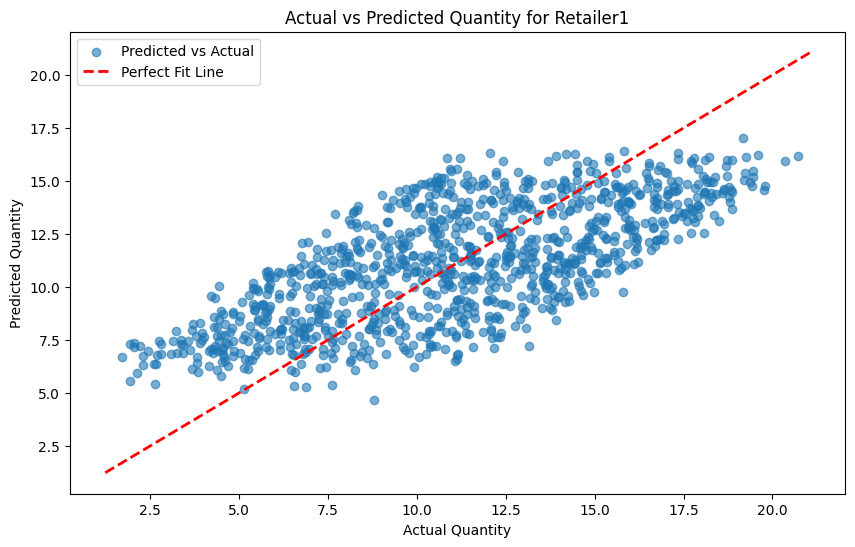

In [30]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, label="Predicted vs Actual")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, color='red', label="Perfect Fit Line")
plt.xlabel('Actual Quantity')
plt.ylabel('Predicted Quantity')
plt.title('Actual vs Predicted Quantity for Retailer1')
plt.legend()
plt.show()


In [25]:
# Add a constant dummy feature to act as an intercept
X['intercept'] = 1

# Verify the new feature
print("Features after adding intercept term:")
print(X.head())


Features after adding intercept term:
   store_id  week  regular_price  competition_1_regular_price  \
0         1     1      10.308645                    10.624815   
1         1     1       7.947956                     7.748726   
2         1     1      13.439368                    13.751508   
3         1     1       5.112777                     5.279713   
4         1     1      14.085425                    14.153721   

   competition_2_regular_price  competition_3_regular_price  \
0                    10.013451                    10.378847   
1                     7.589198                     8.085262   
2                    13.183621                    13.875440   
3                     5.222118                     5.117789   
4                    13.860002                    14.339698   

   competition_4_regular_price  competition_5_regular_price  \
0                     9.910385                    10.298832   
1                     7.602363                     8.296181   
2  

In [26]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

# Predict on the test set
y_pred = gbr.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Gradient Boosting Model with Intercept - Mean Squared Error (MSE): {mse}")
print(f"Gradient Boosting Model with Intercept - Mean Absolute Error (MAE): {mae}")
print(f"Gradient Boosting Model with Intercept - R-squared (R²): {r2}")


Gradient Boosting Model with Intercept - Mean Squared Error (MSE): 8.491289944615177
Gradient Boosting Model with Intercept - Mean Absolute Error (MAE): 2.5367153828628752
Gradient Boosting Model with Intercept - R-squared (R²): 0.4918282976157655


In [29]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.05, 0.01],
    'subsample': [0.8, 1.0]
}

# Initialize GridSearchCV for tuning
grid_search = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42),
                           param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to find the best model
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluate best model on test set
y_pred_best = best_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Best Model - Mean Squared Error (MSE): {mse_best}")
print(f"Best Model - Mean Absolute Error (MAE): {mae_best}")
print(f"Best Model - R-squared (R²): {r2_best}")


Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best Model - Mean Squared Error (MSE): 8.51681951989047
Best Model - Mean Absolute Error (MAE): 2.544520177194829
Best Model - R-squared (R²): 0.49030044874787726


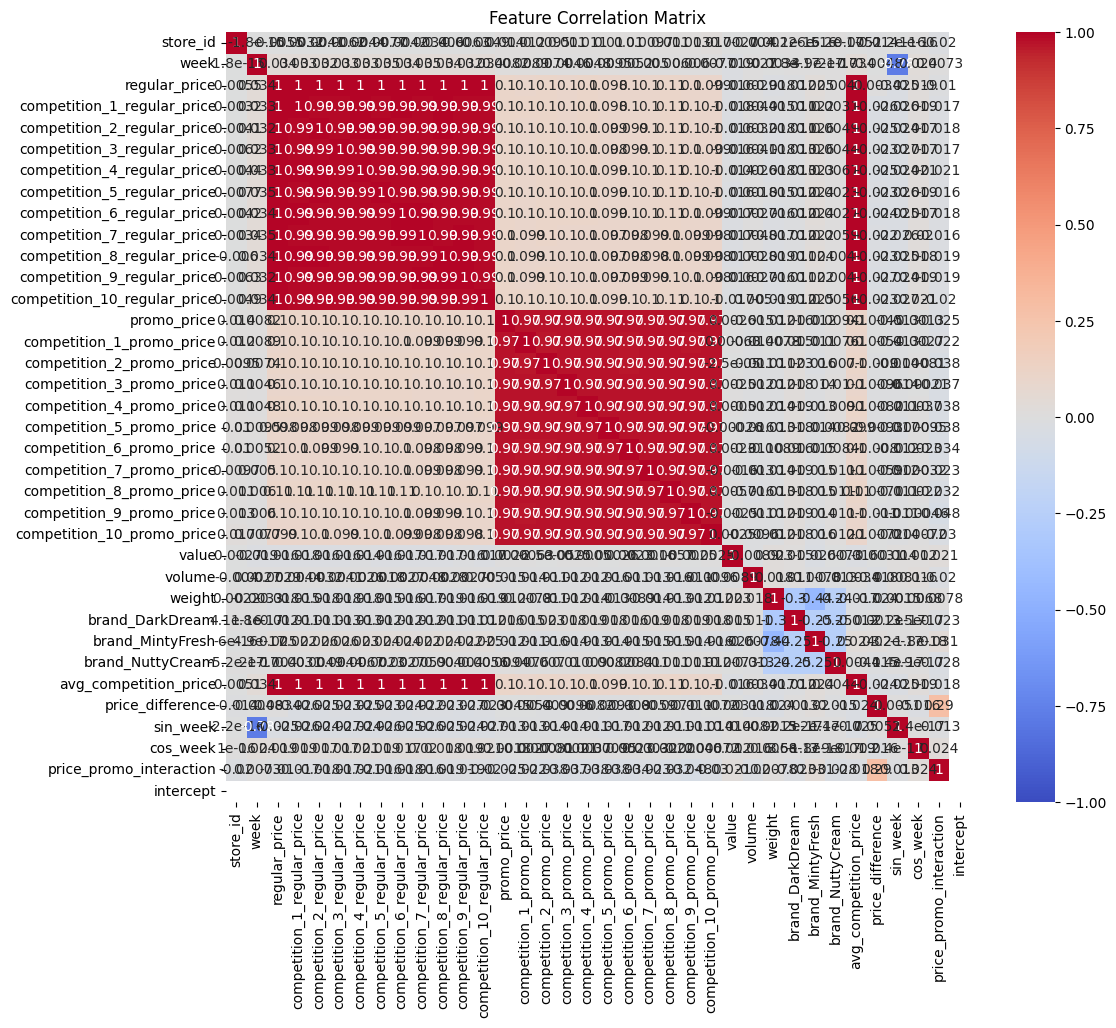

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = X.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix")
plt.show()


In [32]:
# Define features (X) and target (y)
X = df_retailer1.drop(columns=['quantity'])
y = df_retailer1['quantity']


In [33]:
# Drop highly correlated competition price columns
X_dropped = X.drop(columns=[col for col in X.columns if 'competition_' in col and ('regular_price' in col or 'promo_price' in col)])

# Verify the shape and remaining columns
print("Shape of X after dropping collinear features:", X_dropped.shape)


Shape of X after dropping collinear features: (5200, 15)


In [35]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train_dropped, X_test_dropped, y_train, y_test = train_test_split(X_dropped, y, test_size=0.2, random_state=42)

# Initialize and train XGBoost Regressor
xgb_dropped_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_dropped_model.fit(X_train_dropped, y_train)

# Predict and evaluate
y_pred_dropped = xgb_dropped_model.predict(X_test_dropped)
mse_dropped = mean_squared_error(y_test, y_pred_dropped)
mae_dropped = mean_absolute_error(y_test, y_pred_dropped)
r2_dropped = r2_score(y_test, y_pred_dropped)

print("XGBoost Model with Dropped Collinear Features:")
print(f"MSE: {mse_dropped}, MAE: {mae_dropped}, R²: {r2_dropped}")


XGBoost Model with Dropped Collinear Features:
MSE: 10.063105014107299, MAE: 2.71841397412469, R²: 0.39776108934624455


In [36]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize features before applying PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

print("Shape of X after PCA transformation:", X_pca.shape)


Shape of X after PCA transformation: (5200, 11)


In [37]:
# Split PCA-transformed data into training and testing sets
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Initialize and train XGBoost Regressor
xgb_pca_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_pca_model.fit(X_train_pca, y_train)

# Predict and evaluate
y_pred_pca = xgb_pca_model.predict(X_test_pca)
mse_pca = mean_squared_error(y_test, y_pred_pca)
mae_pca = mean_absolute_error(y_test, y_pred_pca)
r2_pca = r2_score(y_test, y_pred_pca)

print("XGBoost Model with PCA-Transformed Features:")
print(f"MSE: {mse_pca}, MAE: {mae_pca}, R²: {r2_pca}")


XGBoost Model with PCA-Transformed Features:
MSE: 10.033736904622646, MAE: 2.68099258370907, R²: 0.39951866002042535


In [38]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Re-define X to include all features without dropping or transforming
X_full = df_retailer1.drop(columns=['quantity'])
y = df_retailer1['quantity']

# Split data into training and testing sets
X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)

# Initialize and train XGBoost Regressor on the full feature set
xgb_full_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_full_model.fit(X_train_full, y_train)

# Predict and evaluate
y_pred_full = xgb_full_model.predict(X_test_full)
mse_full = mean_squared_error(y_test, y_pred_full)
mae_full = mean_absolute_error(y_test, y_pred_full)
r2_full = r2_score(y_test, y_pred_full)

print("XGBoost Model with Full Feature Set:")
print(f"MSE: {mse_full}, MAE: {mae_full}, R²: {r2_full}")


XGBoost Model with Full Feature Set:
MSE: 9.87853397692804, MAE: 2.685578670514348, R²: 0.40880697033558566


In [39]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.05, 0.01],
    'subsample': [0.8, 1.0]
}

# Initialize GridSearchCV for tuning
grid_search_xgb = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
                               param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to find the best model
grid_search_xgb.fit(X_train_full, y_train)

# Get the best model and parameters
best_xgb_model = grid_search_xgb.best_estimator_
print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)

# Evaluate the best model on the test set
y_pred_best_xgb = best_xgb_model.predict(X_test_full)
mse_best_xgb = mean_squared_error(y_test, y_pred_best_xgb)
mae_best_xgb = mean_absolute_error(y_test, y_pred_best_xgb)
r2_best_xgb = r2_score(y_test, y_pred_best_xgb)

print("Tuned XGBoost Model with Full Feature Set:")
print(f"MSE: {mse_best_xgb}, MAE: {mae_best_xgb}, R²: {r2_best_xgb}")


Best Parameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Tuned XGBoost Model with Full Feature Set:
MSE: 8.471866727888028, MAE: 2.538761377637069, R²: 0.49299070393734834


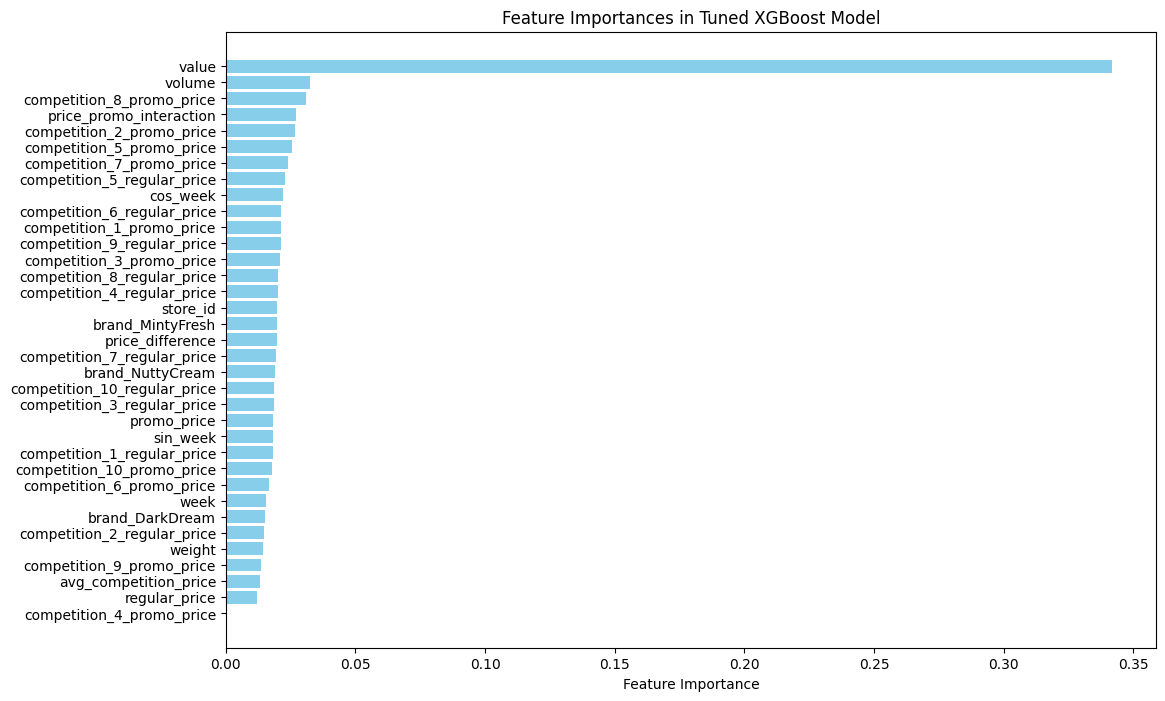

In [40]:
import matplotlib.pyplot as plt

# Get feature importances from the tuned XGBoost model
feature_importances = best_xgb_model.feature_importances_

# Sort feature importances in descending order and match them to feature names
sorted_idx = feature_importances.argsort()[::-1]
sorted_features = X_full.columns[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importances in Tuned XGBoost Model")
plt.gca().invert_yaxis()
plt.show()


In [43]:
from pycaret.regression import *

# Initialize the PyCaret regression setup
exp_reg = setup(data=df_retailer1, target='quantity', session_id=42,
                normalize=True, silent=True, fold=5)  # normalize and use 5-fold cross-validation


ImportError: cannot import name 'threadpool_info' from 'sklearn.utils.fixes' (/home/cian/Ferrero_Tech_Assesment/venv/lib/python3.10/site-packages/sklearn/utils/fixes.py)

In [ ]:
# Compare all models and select the best one based on R²
best_model = compare_models()
